## 生成モデル
- データとして観測される観測変数が何らかの確率モデルから生成されていると仮定し，その生成過程を確率分布によってモデル化するアプローチ
    - 観測変数の背景にある因子(確率変数)として潜在変数も仮定することが多い
- 「データがどのようにできているのか？」を明示的に表すことができ，モデルからデータを生成することができる

## 深層生成モデル
- 観測変数が複雑な場合，単純な確率分布では直接表現できない
    - 特に観測変数がベクトルでその要素(次元)間の依存関係が非線形な場合(画像など)
        - 非線形な関係性を表すには? -> 深層ニューラルネットワーク(DNN)
            - 非線形な関係性とは?
- 深層生成モデル(deep generative mdoels)
    - 確率分布をDNNで表現した生成モデル
    - DNNによって複雑な入力をend-to-endに扱えるようになった
- 生成モデルによって明示的に生成過程をモデル化できる + DNNによって非線形な関係性を捉えられる

## 従来の確率プログラミング言語では近年の複雑な深層生成モデルを実装することが困難
- どういう点でだろうか？M2-model, TD-VAE, FactorVAE

## 深層生成モデルの特徴
- 生成モデルを構成するDNNは確率分布によって隠蔽される
    - 隠蔽されるとは？
- モデルの種類や確率変数の正則化は目的関数(誤差関数)として記述される
- モデルの学習方法はモデル(目的関数)に依存しない

### DNNの隠蔽
- 深層生成モデルを構成する確率分布はDNNによって表現される
    - DNNの構造の詳細は確率分布によって隠蔽される
        - 近年の複雑な深層生成モデルの論文では生成モデルの説明部分ではDNNの詳細は触れられない
            - TD-VAEの論文の中では，各分布を構成するDNNの詳細はAppendixに回されている
- 既存の確率プログラミング言語ではDNNと確率分布を混ぜて書く枠組み(隠蔽ができない)
    - DNNの構造を気にせずに確率分布の操作によって生成モデルを実装できる仕組みが望ましい

#### DNNによる確率分布の表現方法の違い
- DNNで確率分布を表す方法は深層生成モデルの種類によって異なる
    - 条件付き分布p(x|z)をモデル化する
        - VAE, GANなど
    - p(x)を直接モデル化する
        - 自己回帰モデル: 観測変数の各要素の条件付き分布の積で表現
        - flowベースモデル: flowによる変数変換として表現
- 様々な深層生成モデルを統一的に扱うためにも確率分布の操作とそれを構成するDNNの定義は分離する必要がある

### 目的関数によるモデルの定義
- 深層生成モデルではいずれのモデルも最適化するための目的関数を明示的に設定する
    - 自己回帰モデル・フローベースモデル: Kullback-Leiblerダイバージェンス(対数尤度)
    - VAE: 周辺対数尤度の下界
    - GAN: Jensen-Shannonダイバージェンス(ただし目的関数自身の更新も必要)
    
- 推論, 確率変数の表現の正則化なども全て目的関数として追加する
    - 深層生成モデルではモデルの設計=目的関数の定義
    - 従来の生成モデルと異なりサンプリングによる推論等は行わない
        - これを実現するには確率分布を受け取って目的関数を定義できる枠組みが必要

### 学習方法はモデルに依存しない
- 深層生成モデルではモデルに依存せずに勾配降下法で学習する
    - 通常のDNNの学習と同様，様々なモデルに対して任意の最適化アルゴリズムを用いる
    - 従来の生成モデルのようにモデルに応じて決まった学習アルゴリズムが選択されることはない
        - ギブスサンプリング，EMアルゴリズム，変分推論
- 目的関数と最適化アルゴリズムが独立に設定・学習できる枠組みが必要

## 深層生成モデルの特徴を考慮したAPI
- 生成モデルを構成するDNNは確率分布によって隠蔽される
    - DNNの定義と確率分布の操作を分離できる枠組み(Distribution API)
- モデルの種類や確率変数の正則化は目的関数(誤差関数)として記述される
    - 確率分布を受け取って目的関数を定義できる枠組み(Loss API)
- モデルの学習方法はモデル(目的関数)に依存しない
    - 目的関数と最適化アルゴリズムが独立に設定できる枠組み(Model API)

In [11]:
from __future__ import print_function
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from tensorboardX import SummaryWriter

from tqdm import tqdm

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

## VAEの実装を通してそれぞれのAPIの関係を習得する

### 1. Distribution API
- DNNの定義と確率分布の操作を分離できる枠組み(Distribution API)
- https://pixyz.readthedocs.io/en/latest/distributions.html

<img src="tutorial_figs/vae_graphicalmodel.png">

定義する確率分布は以下の通り

Prior: $p(z) = N(z; 0, 1)$

Generator: $p_{\theta}(x|z) = B(x; \lambda = g(z))$

Inference: $q_{\phi}(z|x) = N(z; µ = f_{\mu}(x), \sigma^2 = f_{\sigma^2}(x))$

In [16]:
from pixyz.distributions import Normal, Bernoulli
from pixyz.utils import print_latex

#### priorの確率分布を定義する

priorは平均0, 分散1のガウス分布である

$p(z) = N(z; 0, 1)$

DNNで確率分布を定義しない場合は，pixyz.Distributionクラスを継承せずそのまま利用

In [8]:
# prior
z_dim = 64
prior = Normal(loc=torch.tensor(0.), scale=torch.tensor(1.),
              var=["z"], features_shape=[z_dim], name="p_{prior}").to(device)
print(prior)
print_latex(prior)

Distribution:
  p_{prior}(z)
Network architecture:
  Normal(
    name=p_{prior}, distribution_name=Normal,
    var=['z'], cond_var=[], input_var=[], features_shape=torch.Size([64])
    (loc): torch.Size([1, 64])
    (scale): torch.Size([1, 64])
  )


<IPython.core.display.Math object>

#### generatorの確率分布を定義する
Generatorは~なベルヌーイ分布

$p_{\theta}(x|z) = B(x; \lambda = g(z))$

pixyz.Distributionクラスを継承してDNNによる確率分布を定義する

In [15]:
x_dim = 784
# generative model p(x|z)    
class Generator(Bernoulli):
    def __init__(self):
        super(Generator, self).__init__(cond_var=["z"], var=["x"], name="p")

        self.fc1 = nn.Linear(z_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, x_dim)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        return {"probs": torch.sigmoid(self.fc3(h))}
p = Generator().to(device)
print(p)
print_latex(p)

Distribution:
  p(x|z)
Network architecture:
  Generator(
    name=p, distribution_name=Bernoulli,
    var=['x'], cond_var=['z'], input_var=['z'], features_shape=torch.Size([])
    (fc1): Linear(in_features=64, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=784, bias=True)
  )


<IPython.core.display.Math object>

#### Inferenceの確率分布を定義する

Inferenceは~なガウス分布

$q_{\phi}(z|x) = N(z; µ = f_{\mu}(x), \sigma^2 = f_{\sigma^2}(x))$

In [19]:
# inference model q(z|x)
class Inference(Normal):
    def __init__(self):
        super(Inference, self).__init__(cond_var=["x"], var=["z"], name="q")

        self.fc1 = nn.Linear(x_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc31 = nn.Linear(512, z_dim)
        self.fc32 = nn.Linear(512, z_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return {"loc": self.fc31(h), "scale": F.softplus(self.fc32(h))}

q = Inference().to(device)
print(q)
print_latex(q)

Distribution:
  q(z|x)
Network architecture:
  Inference(
    name=q, distribution_name=Normal,
    var=['z'], cond_var=['x'], input_var=['x'], features_shape=torch.Size([])
    (fc1): Linear(in_features=784, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fc31): Linear(in_features=512, out_features=64, bias=True)
    (fc32): Linear(in_features=512, out_features=64, bias=True)
  )


<IPython.core.display.Math object>

#### 確率分布からのサンプリング
- 定義したDistributionクラスは，DNNの構造や分布に依存せず，同じAPI( .sample() )でサンプリングが可能
- Pixyzではサンプルは辞書形式で扱われる(keyが変数名, valueが実際のサンプル)

$z\sim p(z)$

In [35]:
# z ~ p(z)
prior_samples = prior.sample(batch_n=1)
print(prior_samples)
print(prior_samples.keys())
print(prior_samples['z'].shape)

{'z': tensor([[-0.4775, -0.8768, -0.2455, -1.0976,  0.5487, -2.4394,  0.0080, -0.7232,
          1.6980,  0.4508, -0.7300, -0.2915,  0.3533, -0.7052,  0.2204,  2.2149,
          0.0972,  1.0809,  2.5791,  0.0590, -0.6338,  0.9766,  0.7509, -0.2403,
          0.0950,  0.3797,  2.1962, -0.9363,  0.5456,  0.6788, -2.0669,  0.5640,
          1.0697,  1.0394,  0.8876, -0.1303, -0.5416,  0.7315, -1.2694, -0.5596,
          0.5634,  0.6056, -0.9672,  0.3043,  0.6656,  0.3016, -1.2035,  0.1537,
         -0.3992, -1.9907, -0.3038,  1.0043, -1.2753, -0.6404, -0.1856, -1.5653,
          0.1191, -0.0673,  0.4504,  0.6434, -1.1470, -0.7804,  1.4679, -1.8744]])}
dict_keys(['z'])
torch.Size([1, 64])


#### 同時分布を分布同士の掛け算で表現できる
- Distribution APIでは分布同士の掛け算で同時分布を表現できる
    - 掛け算の結果も同様にサンプリング可能
- Todo: サンプル同士の値の受け渡しについて

$p_{\theta}(x, z) = p_{\theta}(x|z)p(z)$

In [29]:
p_joint = p * prior
print(p_joint)
print_latex(p_joint)

Distribution:
  p(x,z) = p(x|z)p_{prior}(z)
Network architecture:
  Normal(
    name=p_{prior}, distribution_name=Normal,
    var=['z'], cond_var=[], input_var=[], features_shape=torch.Size([64])
    (loc): torch.Size([1, 64])
    (scale): torch.Size([1, 64])
  )
  Generator(
    name=p, distribution_name=Bernoulli,
    var=['x'], cond_var=['z'], input_var=['z'], features_shape=torch.Size([])
    (fc1): Linear(in_features=64, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=784, bias=True)
  )


<IPython.core.display.Math object>

#### 同時分布からのサンプリング

$x, z \sim p_{\theta}(x, z) $

In [34]:
p_joint_samples = p_joint.sample(batch_n=1)
print(p_joint_samples)
print(p_joint_samples.keys())
print(p_joint_samples['x'].shape)
print(p_joint_samples['z'].shape)

{'z': tensor([[ 0.6911, -0.2151, -0.2240, -1.3010, -0.7158,  1.0058, -0.1969,  1.9033,
          0.5763, -0.2060, -0.2550, -1.8752, -0.2079, -1.3141,  0.2784,  1.9367,
          1.4714, -0.5514, -1.1762,  0.3228, -0.3911, -0.5594, -0.1994,  0.8338,
         -0.5659,  0.7743,  0.4976,  1.2512, -1.1920,  0.1378,  1.5434,  0.6418,
         -0.7074, -0.8534,  0.0434, -1.5009, -1.0124,  0.0564,  0.6456, -0.9286,
          0.3570,  0.0089,  0.4668, -1.5784,  0.4568,  0.0966, -0.5067,  0.3962,
         -0.6921, -0.5560, -1.7292, -0.8398,  0.1524, -0.3936, -2.0018,  1.6253,
          1.5775,  0.3268,  0.3798,  1.3117,  0.9418,  0.9301,  0.2128,  0.7584]]), 'x': tensor([[1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0.,
         0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0.,
         1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
         1., 0

#### より詳細なDistribution API Turorial
- 00-distribution.ipynb

### 2. Loss API
- 確率分布を受け取って目的関数を定義できる枠組み
    - pixyz.Lossは，Distributionを受け取ってLossを定義する
        - Lossクラス同士は演算が可能なため，任意のLossを設計することができる
            - -> 論文の式をそのまま実装に落とし込める
- Lossの値は，データを与えると評価できる
    - 各Lossはシンボルとして扱われる(式を定義し，あたいはデータを入れるまで評価されない)
        - データやDNNに依存せずに，明示的に確率モデルを設計できる->Define-and-run的

VAEのLossは以下の通り
$$
\mathcal { L } _ { \mathrm { VAE } } ( \theta , \phi ) =   \mathbb { E } _ { p_{data}( x ) } \left [D _ { \mathrm { KL } } \left[ q _ \phi ( z | x ) \| p ( z ) \right] - \mathbb { E } _ { q _ { \phi } ( z | x ) } \left[\log p _ { \theta } ( x | z ) \right]\right]
$$

#### Lossをpixyz.distributionとpixyz.lossで定義する

$D _ { \mathrm { KL } } \left[ q _ \phi ( z | x ) \| p ( z ) \right]$

In [42]:
from pixyz.losses import KullbackLeibler
kl = KullbackLeibler(q, prior)
print_latex(kl)

<IPython.core.display.Math object>

In [43]:
from pixyz.losses import StochasticReconstructionLoss
reconst = StochasticReconstructionLoss(q, p)
print_latex(reconst)

<IPython.core.display.Math object>

#### Lossクラス同士の演算

In [47]:
vae_loss = (kl + reconst).mean()
print_latex(vae_loss)

<IPython.core.display.Math object>

#### データを与え，Lossを評価する
- .eval()でLossの計算が行われる

In [73]:
#Todo: 何をevalの時渡すのか
dummy_x = torch.randn([4, 784])
vae_loss.eval({"x": dummy_x})

tensor(522.8806, grad_fn=<MeanBackward0>)

#### より詳細なLoss API Turorial
- loss-tutorial.ipynb

### 3. Model API
- 目的関数と最適化アルゴリズムが独立に設定できる枠組み
- Lossと最適化アルゴリズムを設定し，データを入れて訓練

In [58]:
from pixyz.models import Model
# todo: distributionsに格納する確率分布はどのように判断するのか
# Modelを使わずに学習を行う方法
# Model.train()の処理が何しているかの可視化
model = Model(loss=vae_loss, distributions=[p, q],
             optimizer=optim.Adam, optimizer_params={"lr": 1e-3})
print(model)
print_latex(model)

Distributions (for training): 
  p(x|z), q(z|x) 
Loss function: 
  mean \left(D_{KL} \left[q(z|x)||p_{prior}(z) \right] - \mathbb{E}_{q(z|x)} \left[\log p(x|z) \right] \right) 
Optimizer: 
  Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 0.001
      weight_decay: 0
  )


<IPython.core.display.Math object>

In [74]:
dummy_x = torch.randn([10, 784])
def train_dummy(epoch):
    global dummy_x
    dummy_x = dummy_x.to(device)
    loss = model.train({"x": dummy_x})
    print('Epoch: {} Train Loss: {:4f}'.format(epoch, loss))

In [75]:
for epoch in range(10):
    train_dummy(epoch)

Epoch: 0 Train Loss: 120.133484
Epoch: 1 Train Loss: 72.659431
Epoch: 2 Train Loss: 22.168152
Epoch: 3 Train Loss: -23.844059
Epoch: 4 Train Loss: -120.677345
Epoch: 5 Train Loss: -188.897781
Epoch: 6 Train Loss: -260.247894
Epoch: 7 Train Loss: -335.725891
Epoch: 8 Train Loss: -402.313812
Epoch: 9 Train Loss: -484.476166


#### より詳細なModel API Turorial
- model-tutorial.ipynb

### MNISTデータセットを用いてPixyz版VAEを学習する
Todo: コメント方針の決定

#### 必要なモジュールのインストールなど

In [124]:
from __future__ import print_function
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
from tensorboardX import SummaryWriter

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

batch_size = 256
epochs = 3
seed = 1
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"


#### MNISTデータセットの準備

In [108]:
root = 'data'
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambd=lambda x: x.view(-1))])
kwargs = {'batch_size': batch_size, 'num_workers': 1, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root=root, train=True, transform=transform, download=True),
    shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root=root, train=False, transform=transform),
    shuffle=False, **kwargs)

#### Pixyzモジュールのインストール

In [109]:
from pixyz.distributions import Normal, Bernoulli
from pixyz.losses import KullbackLeibler, Expectation as E
from pixyz.models import Model
from pixyz.utils import print_latex

#### 確率分布の定義

In [110]:
x_dim = 784
z_dim = 64


# inference model q(z|x)
class Inference(Normal):
    def __init__(self):
        super(Inference, self).__init__(cond_var=["x"], var=["z"], name="q")

        self.fc1 = nn.Linear(x_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc31 = nn.Linear(512, z_dim)
        self.fc32 = nn.Linear(512, z_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return {"loc": self.fc31(h), "scale": F.softplus(self.fc32(h))}

    
# generative model p(x|z)    
class Generator(Bernoulli):
    def __init__(self):
        super(Generator, self).__init__(cond_var=["z"], var=["x"], name="p")

        self.fc1 = nn.Linear(z_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, x_dim)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        return {"probs": torch.sigmoid(self.fc3(h))}
    
p = Generator().to(device)
q = Inference().to(device)

prior = Normal(loc=torch.tensor(0.), scale=torch.tensor(1.),
               var=["z"], features_shape=[z_dim], name="p_{prior}").to(device)

In [111]:
print(prior)
print_latex(prior)

Distribution:
  p_{prior}(z)
Network architecture:
  Normal(
    name=p_{prior}, distribution_name=Normal,
    var=['z'], cond_var=[], input_var=[], features_shape=torch.Size([64])
    (loc): torch.Size([1, 64])
    (scale): torch.Size([1, 64])
  )


<IPython.core.display.Math object>

In [112]:
print(p)
print_latex(p)

Distribution:
  p(x|z)
Network architecture:
  Generator(
    name=p, distribution_name=Bernoulli,
    var=['x'], cond_var=['z'], input_var=['z'], features_shape=torch.Size([])
    (fc1): Linear(in_features=64, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=784, bias=True)
  )


<IPython.core.display.Math object>

In [113]:
print(q)
print_latex(q)

Distribution:
  q(z|x)
Network architecture:
  Inference(
    name=q, distribution_name=Normal,
    var=['z'], cond_var=['x'], input_var=['x'], features_shape=torch.Size([])
    (fc1): Linear(in_features=784, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fc31): Linear(in_features=512, out_features=64, bias=True)
    (fc32): Linear(in_features=512, out_features=64, bias=True)
  )


<IPython.core.display.Math object>

#### Lossの定義

In [114]:
kl = KullbackLeibler(q, prior)
reconst = StochasticReconstructionLoss(q, p)
vae_loss = (kl + reconst).mean()
print_latex(vae_loss)

<IPython.core.display.Math object>

#### 最適化アルゴリズムとモデルの設定

In [115]:
model = Model(loss=vae_loss, distributions=[p, q],
             optimizer=optim.Adam, optimizer_params={"lr": 1e-3})
print(model)
print_latex(model)

Distributions (for training): 
  p(x|z), q(z|x) 
Loss function: 
  mean \left(D_{KL} \left[q(z|x)||p_{prior}(z) \right] - \mathbb{E}_{q(z|x)} \left[\log p(x|z) \right] \right) 
Optimizer: 
  Adam (
  Parameter Group 0
      amsgrad: False
      betas: (0.9, 0.999)
      eps: 1e-08
      lr: 0.001
      weight_decay: 0
  )


<IPython.core.display.Math object>

In [116]:
def train(epoch):
    train_loss = 0
    #for x, _ in tqdm(train_loader):
    for x, _ in train_loader:
        x = x.to(device)
        loss = model.train({"x": x})
        train_loss += loss
 
    train_loss = train_loss * train_loader.batch_size / len(train_loader.dataset)
    print('Epoch: {} Train loss: {:.4f}'.format(epoch, train_loss))
    return train_loss

def test(epoch):
    test_loss = 0
    #for x, _ in tqdm(test_loader):
    for x, _ in test_loader:
        x = x.to(device)
        loss = model.test({"x": x})
        test_loss += loss

    test_loss = test_loss * test_loader.batch_size / len(test_loader.dataset)
    print('Test loss: {:.4f}'.format(test_loss))
    return test_loss

#### 再構成

In [117]:
def plot_reconstrunction(x):
    with torch.no_grad():
        z = q.sample({"x": x}, return_all=False)
        recon_batch = p.sample_mean(z).view(-1, 1, 28, 28)
    
        comparison = torch.cat([x.view(-1, 1, 28, 28), recon_batch]).cpu()
        return comparison

#### 潜在変数空間からの生成

In [118]:
def plot_image_from_latent(z_sample):
    with torch.no_grad():
        sample = p.sample_mean({"z": z_sample}).view(-1, 1, 28, 28).cpu()
        return sample

In [119]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Epoch: 1 Train loss: 128.0035
Test loss: 124.8207
Epoch: 1
Reconstruction


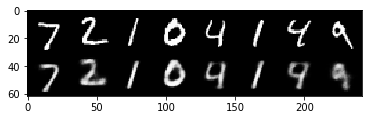

generate from prior z:


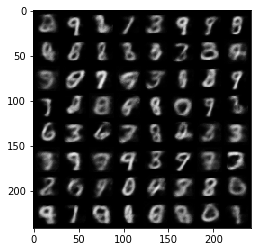

Epoch: 2 Train loss: 119.8559
Test loss: 117.9434
Epoch: 2
Reconstruction


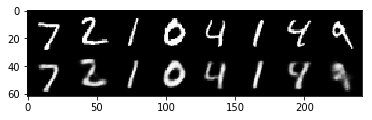

generate from prior z:


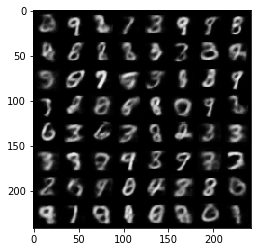

Epoch: 3 Train loss: 115.0016
Test loss: 114.9668
Epoch: 3
Reconstruction


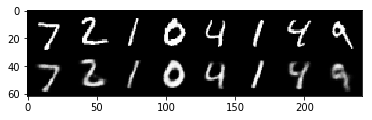

generate from prior z:


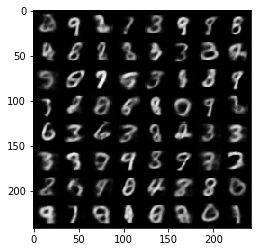

In [125]:
# z_sample for generate imgs from prior
z_sample = 0.5 * torch.randn(64, z_dim).to(device)

# fixed _x for watching reconstruction improvement
_x, _ = iter(test_loader).next()
_x = _x.to(device)

for epoch in range(1, epochs + 1):
    train_loss = train(epoch)
    test_loss = test(epoch)
    
    recon = plot_reconstrunction(_x[:8])
    sample = plot_image_from_latent(z_sample)
    
    print('Epoch: {}'.format(epoch))
    print('Reconstruction')
    imshow(torchvision.utils.make_grid(recon))
    print('generate from prior z:')
    imshow(torchvision.utils.make_grid(sample))

In [18]:
from __future__ import print_function
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms

from tqdm import tqdm

batch_size = 128
epochs = 10
seed = 1
torch.manual_seed(seed)

root = '../data'
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Lambda(lambd=lambda x: x.view(-1))])
kwargs = {'batch_size': batch_size, 'num_workers': 1, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root=root, train=True, transform=transform, download=True),
    shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root=root, train=False, transform=transform),
    shuffle=False, **kwargs)

In [19]:
from pixyz.distributions import Normal, Bernoulli
from pixyz.losses import KullbackLeibler, StochasticReconstructionLoss
from pixyz.models import VAE, Model
from pixyz.utils import print_latex
x_dim = 784
z_dim = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [32]:
# Distribution APIの良さみ
class Inference(Normal):
    def __init__(self):
        super(Inference, self).__init__(cond_var=['x'], var=['z'], name='q')
        self.fc1 = nn.Linear(x_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc31 = nn.Linear(512, z_dim)
        self.fc32 = nn.Linear(512, z_dim)
        
    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return {'loc': self.fc31(h), 'scale': F.softplus(self.fc32(h))}


# generative model p(x|z)
class Generator(Bernoulli):
    def __init__(self):
        super(Generator, self).__init__(cond_var=['z'], var=['x'], name='p')
        
        self.fc1 = nn.Linear(z_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, x_dim)
    
    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        return {'probs': torch.sigmoid(self.fc3(h))}

# distributions API
p = Generator().to(device)
q = Inference().to(device)

prior = Normal(loc=torch.tensor(0.), scale=torch.tensor(1.),
              var=['z'], features_shape=[z_dim], name='p_{prior}').to(device)
# distributions APIに従うことでsample()だったり, 分布の掛け算などが手軽に定義できる
# 生成過程を確率分布によってモデル化するという意識を忘れずに，今自分は何を実装しているんだ？と確認させてくれる
# オレオレ実装が少なくなり得る可能性はここにあるのか？

# 確率分布として扱うからこそのloss APIの融通
kl = KullbackLeibler(q, prior)
reconst = StochasticReconstructionLoss(q, p)
loss = (kl + reconst).mean()

# これがさらに上位のmodel APIによっていい感じに定義できる
model = Model(loss=loss, distributions=[p, q],
             optimizer=optim.Adam, optimizer_params={'lr': 1e-3})

def train(epoch):
    train_loss = 0
    for x, _ in tqdm(train_loader):
        x = x.to(device)
        loss = model.train({'x': x})
        train_loss += loss
    
    train_loss = train_loss * train_loader.batch_size / len(train_loader.dataset)
    print('Epoch: {} Train loss: {:.4f}'.format(epoch, train_loss))
    return train_loss

class Inference_npx(nn.Module):
    def __init__(self):
        super(Inference_npx, self).__init__()
        self.fc1 = nn.Linear(x_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc31 = nn.Linear(512, z_dim)
        self.fc32 = nn.Linear(512, z_dim)
    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return {'loc': self.fc31(h), 'scale': F.softplus(self.fc32(h))}


class Generator_npx(nn.Module):
    def __init__(self):
        super(Generator_npx, self).__init__()
        self.fc1 = nn.Linear(z_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, x_dim)
    
    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        return {'probs': torch.sigmoid(self.fc3(h))}

class VAE_npx(nn.Module):
    def __init__(self, inference, generator):
        super(VAE_npx, self).__init__()
        
        self.inference = inference
        self.generator = generator
        
    def encode(self, x):
        return self.inference(x)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        
        # Returns a tensor with the same size as std 
        # that is filled with random numbers from a normal distribution with mean 0 and variance 1
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.generator(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)['loc'], self.encode(x)['scale']
        z = self.reparameterize(mu, logvar)
        recon_batch = self.decode(z)['probs']
        return recon_batch, mu, logvar
p = Inference_npx()
q = Generator_npx()
model_npx = VAE_npx(p, q).to(device)
optimizer = optim.Adam(params=model_npx.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    # 0.5 * sum(1 + log(sigma^2) - mu ^2 - sigma ^ 2)
    KLD = - 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

def train_npx(epoch):
    model_npx.train()
    train_loss = 0
    for batch_idx, (data, _) in tqdm(enumerate(train_loader)):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar  = model_npx(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

In [26]:
train(3)

 12%|█▏        | 57/469 [00:04<00:29, 13.87it/s]


KeyboardInterrupt: 

In [33]:
train_npx(3)

469it [00:30, 15.14it/s]


In [ ]:
class Distribution(nn.Module):
    def __init__(self, var, cond_var=[], name='p', features_shape=torch.Size()):
        '''
        var: obj list of str
        variables of this distrbution
        cond_var conditional variables of this ditribution
        name name of this distribution
        features_shape shape of dimensions
        '''
        super().__init__()
        _vars = len(_vars) != cond_var + var
        if len(_vars) != len(set(_vars)):
            raise ValueError('there are conflicted variables')
        self._cond_var = con_var
        self._var = var
        
        self._features_shape = torch.Size(features_shape)
        self._name = convert_latex_name(name)
        
        self._prob_text = None
        self._prob_factorized_text = None
        
    @property
    def distribution_name(self):
        return ''
    
    @property
    def distribution_name(self):
        return self._name
    
    @name.setter
    def name(self, name):
        if type(name) is str:
            self._name = name
            return
        raise ValueError('name of the distribution class must be a string type')
    
    @property
    def var(self):
        return self._var
    
    @propety
    def cond_var(self):
        return self._cond_var
    
    @property
    def input_var(self):
        # input varialbes of this distribution
        return self._cond_var
    
    @property
    def prob_text(self):
        """str: Return a formula of the (joint) probability distribution."""
        _var_text = [','.join([convert_latex_name(var_name) for var_name in self._var])]
        if len(self._cond_var) != 0:
            _var_text += [','.join([convert_latex_name(var_name) for var_name in self._cond_var])]

        _prob_text = "{}({})".format(
            self._name,
            "|".join(_var_text)
        )

        return _prob_text

    @property
    def prob_factorized_text(self):
        """str: Return a formula of the factorized probability distribution."""
        return self.prob_text

    @property
    def prob_joint_factorized_and_text(self):
        """str: Return a formula of the factorized and the (joint) probability distributions."""
        if self.prob_factorized_text == self.prob_text:
            prob_text = self.prob_text
        else:
            prob_text = "{} = {}".format(self.prob_text, self.prob_factorized_text)
        return prob_text

    @property
    def features_shape(self):
        """torch.Size or list: Shape of features of this distribution."""
        return self._features_shape

    def _check_input(self, input, var=None):
        """Check the type of given input.
        If the input type is :obj:`dict`, this method checks whether the input keys contains the :attr:`var` list.
        In case that its type is :obj:`list` or :obj:`tensor`, it returns the output formatted in :obj:`dict`.
        Parameters
        ----------
        input : :obj:`torch.Tensor`, :obj:`list`, or :obj:`dict`
            Input variables.
        var : :obj:`list` or :obj:`NoneType`, defaults to None
            Variables to check if given input contains them.
            This is set to None by default.
        Returns
        -------
        input_dict : dict
            Variables checked in this method.
        Raises
        ------
        ValueError
            Raises `ValueError` if the type of input is neither :obj:`torch.Tensor`, :obj:`list`, nor :obj:`dict.
        """
        if var is None:
            var = self.input_var

        if type(input) is torch.Tensor:
            input_dict = {var[0]: input}

        elif type(input) is list:
            # TODO: we need to check if all the elements contained in this list are torch.Tensor.
            input_dict = dict(zip(var, input))

        elif type(input) is dict:
            if not (set(list(input.keys())) >= set(var)):
                raise ValueError("Input keys are not valid.")
            input_dict = input.copy()

        else:
            raise ValueError("The type of input is not valid, got %s." % type(input))

        return input_dict
        